<a href="https://colab.research.google.com/github/ahmadpnb/combinationforecast/blob/main/Anis_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#please install all packages if not available, can use similar code as shown below for installation. Once installed, no need to reinstall
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 17.4 MB/s eta 0:00:00


In [ ]:
#packages needed for this script

import pandas as pd #package for data handling
import numpy as np #package for default arithmetic
import matplotlib.pyplot as plt #package for plotting graph
import seaborn as sns #package for plotting graph
import statsmodels.api as sm #package for models and other statistical test
from statsmodels.tsa.stattools import adfuller #package for ADF test for stationarity
from arch.unitroot import PhillipsPerron #package for Phillips Perron test for stationarity
from statsmodels.tsa.stattools import kpss #package for KPSS test for stationarity
from statsmodels.tsa.stattools import acf, pacf #package for acf and pacf
from statsmodels.tsa.arima.model import ARIMA #package for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #package to plot autocorrelation function and partial
from statsmodels.stats.diagnostic import acorr_ljungbox #package for ljungbox text for white noise
from sklearn.model_selection import train_test_split #for train_test

In [ ]:
# Functions for EDA

def eda(df):
  print(df.info())
  print()
  print()
  display(df.head(10), df.tail(10))
  print()
  print()
  print('Data summary statistics')
  display(df.describe())
  print()
  print()
  df.select_dtypes(include = np.number).plot(subplots = True, sharex = True, figsize = (11.69,8.27), use_index = True, title = "Graphs of all variables", legend = True, xlabel = "Date")
  plt.show()
  print()
  print()
  pairplot = sns.pairplot(data = df.select_dtypes(include = np.number), kind = "reg", diag_kind = "hist", dropna = True)
  pairplot.fig.subplots_adjust(top = .95)
  pairplot.fig.suptitle("Variables distribution and two way relationships")
  plt.show()
  print()
  print()
  sns.heatmap(data = df.corr(numeric_only = True), cmap = "RdYlGn", center = 0, robust = True, square = True, annot = True, fmt = ".0%", linewidth = 0.5)
  plt.title("Correlation matrix between variables")
  plt.show()

In [ ]:
# functions for transformation

# function to log selected columns
def transform_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].transform(np.log)

  return df


# function to difference selected columns
def transform_diff(df, second_diff = False):

  print(df.columns)
  input_string = input("Enter all columns' name to be diff separated by space: ")
  columns = input_string.split(" ")

  second_diff = int(input("1 if need second difference, 0 if do not need second difference: "))

  for i in columns:
    print("Column: " + i)
    df[i] = df[i].diff(int(input("Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  if second_diff == True:
      print(df.columns)
      input_string_2 = input("Enter all columns' name to be second differenced separated by space: ")
      columns_2 = input_string_2.split(" ")

      for i in columns_2:
        print("Column: " + i)
        df[i] = df[i].diff(int(input("Please enter the number of second difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  return df


# function to perform data transformation
def transform_data(df, to_log = False, to_diff = False):

  transform = df.copy()
  to_log = int(input("1 if need to log, 0 if no need to log: "))
  to_diff = int(input("1 if need to diff, 0 if no need to diff: "))

  if to_log == True and to_diff == False:
    transform_log(transform)

  elif to_log == False and to_diff == True:
    transform_diff(transform)

  elif to_log == True and to_diff == True:
    transform_log(transform)
    transform_diff(transform)

  return transform


# function to invert differenced columns
def invert_diff(original_df, differenced_df, second_diff = False):

    second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

    if second_diff == True:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo second differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        second_d = int(input("Please insert the number of difference for the second difference: "))
        diff = original_df[i].diff(first_d)
        first_invert = diff.shift(second_d) + differenced_df[i]
        second_invert = original_df[i].shift(first_d) + first_invert
        differenced_df[i] = second_invert

      print(original_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    elif second_diff == False:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo first differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    return differenced_df


# Function to invert log transformation
def invert_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be inverted its log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].apply(np.exp)

  return df


# Function to perform inverse transformation
def inverse_transformation(original_data, differenced_data, log = False, diff = False):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

In [ ]:
# Functions for testing

# function for colour formatting for pvalue - hypothesis testing
def pvalue_formatting(col):
    if col.name == '10%':
        return ['background-color: green' if c < 0.1 else 'background-color: red' for c in col.values]
    if col.name == '5%':
        return ['background-color: green' if c < 0.05 else 'background-color: red' for c in col.values]
    if col.name == '1%':
        return ['background-color: green' if c < 0.01 else 'background-color: red' for c in col.values]

def pvalue_formatting2(col):
    if col.name == '10%':
        return ['background-color: red' if c < 0.1 else 'background-color: green' for c in col.values]
    if col.name == '5%':
        return ['background-color: red' if c < 0.05 else 'background-color: green' for c in col.values]
    if col.name == '1%':
        return ['background-color: red' if c < 0.01 else 'background-color: green' for c in col.values]


# function to perform ADF test
def adf_test(df):

  indicator = []
  pvalue = []

  for column in df:
    adf = adfuller(df[column], regression = 'ct')
    p_value = adf[1]
    indicator.append(column)
    pvalue.append(p_value)

  adf_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("ADF test for stationarity: H0 is time series is not stationary")
  display(adf_test)


# Function to perform Phillips Perron test
def pp_test(df):

  indicator = []
  pvalue = []

  for column in df:
    pp = PhillipsPerron(df[column])
    p_value = pp.pvalue
    indicator.append(column)
    pvalue.append(p_value)

  pp_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("PP test for stationarity: H0 is time series is not stationary")
  display(pp_test)


# Function to perform KPSS test
def kpss_test(df):

  indicator = []
  pvalue = []

  for column in df:
    kpss_test = kpss(df[column], regression = 'ct')
    p_value = kpss_test[1]
    indicator.append(column)
    pvalue.append(p_value)

  kpss_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print("KPSS test for stationarity: H0 is time series is stationary")
  display(kpss_test)


# Function to perform all stationarity test
def stationarity_test(df):

  print("Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise")
  print()
  adf_test(df)
  print()
  pp_test(df)
  print()
  kpss_test(df)


# Function to estimate ACF and PACF for autocorrelation
def acf_pacf_analysis(x, max_lags=24):
    acf_values = sm.tsa.acf(x)
    pacf_values = sm.tsa.pacf(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.suptitle("ACF and PACF graph for " + x.name)
    plt.show()


# Function to graph ACF and PACF
def acf_pacf_graph(df):
  for column in df:
    acf_pacf_analysis(df[column])

# Function for accuracy testing
def forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',input("Please put model name: ")," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

# Function for random walk accuracy testing
def rw_forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',"Random walk model"," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

def adjust(val, length= 6): return str(val).ljust(length)


# Function to find the optimal lag for VECM model

def vecm_optimal_lag(df):

  if df.index.freq == 'm':
    lags = 12
    seasons = 12
  elif df.index.freq == 'q':
    lags = 4
    seasons = 4

  deterministic = input("n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): ")

  result = select_order(df, deterministic = deterministic, maxlags = lags, seasons = seasons)
  print()
  print()
  print(result.summary())
  print()
  print()
  lag = [result.aic, result.bic, result.fpe, result.hqic]
  if len(st.multimode(lag)) != 1:
    optimal_lag = result.aic
  elif len(st.multimode(lag)) == 1:
    optimal_lag = st.mode(lag)
  print("The optimal lag for the model is",optimal_lag)

  return optimal_lag


# Functio to test cointegration rank

def cointegration_test(df):

  lag = int(input("Insert optimal lag number obtained from test: "))
  deterministic = int(input("-1 - no deterministic terms, 0 - constant term, 1 - linear trend "))
  result = coint_johansen(df, det_order = deterministic, k_ar_diff = lag)
  null = ['r = 0', 'r <= 1', 'r <= 2']
  trace_stat = result.trace_stat.tolist()
  trace_stat_crit_vals = result.trace_stat_crit_vals.tolist()
  a,b,c = trace_stat_crit_vals
  max_eig_stat = result.max_eig_stat.tolist()
  max_eig_stat_crit_vals = result.max_eig_stat_crit_vals.tolist()
  d,e,f = trace_stat_crit_vals
  table = pd.DataFrame({'Null Hypothesis of cointegration rank':null,'Trace statistic':trace_stat,'Trace statistic critical values at 99%':a,'Trace statistic critical values at 95%':b,'Trace statistic critical values at 90%':c,'Maximum eigenvalue statistic':max_eig_stat,'Maximum eigenvalue statistic critical values at 99%':d,'Maximum eigenvalue statistic critical values at 95%':e,'Maximum eigenvalue statistic critical values at 90%':f})
  print()
  print()
  display(table)
  print()
  print()
  trace_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "trace")
  print(trace_coint_rank_result.summary())
  print("Trace method cointegration test suggest a cointegration rank of",trace_coint_rank_result.rank)
  print()
  print()
  maxeig_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "maxeig")
  print(maxeig_coint_rank_result.summary())
  print("Maximum Eigenvalue method cointegration test suggest a cointegration rank of",maxeig_coint_rank_result.rank)
  rank = [trace_coint_rank_result.rank, maxeig_coint_rank_result.rank]
  if trace_coint_rank_result.rank != maxeig_coint_rank_result.rank:
    coint_rank = trace_coint_rank_result.rank
  else:
    coint_rank = st.mode(rank)

  return coint_rank

In [ ]:
# Function to run ARIMA model

def arima_model(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by comma: ").lower()
  variables_list  = variables_input.split(",")

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")
  model = ARIMA(transformed_df, order = (int(input("Please put the desired AR process number: ")), int(input("Please put the desired number of difference: ")), int(input("Please put the desired MA process number: "))), seasonal_order = (int(input("Please put the desired seasonal AR process number: ")), int(input("Please put the desired number of seasonal differnce: ")), int(input("Please put the desired seasonal MA process number: ")), int(input("Please put the frequency of the data: "))))
  fit = model.fit()
  residual = fit.resid
  predict = fit.predict().to_frame().rename(columns = {'predicted_mean':model.endog_names})
  actual = og_df.loc[predict.index[0]:predict.index[-1]]

  random_walk_model = ARIMA(og_df, order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_residual = randow_walk_fit.resid
  random_walk_predict = randow_walk_fit.predict().to_frame().rename(columns = {'predicted_mean':model.endog_names})
  random_walk_actual = og_df.loc[random_walk_predict.index[0]:random_walk_predict.index[-1]]

  print()
  print("Inversing model fitted value")
  predict = inverse_transformation(og_df, predict)

  het_tstat, het_pvalue = [item for sublist in fit.test_heteroskedasticity(method = 'breakvar').tolist() for item in sublist]
  hetero_test = pd.DataFrame({'10%':[het_pvalue],'5%':[het_pvalue],'1%':[het_pvalue]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  nor_tstat, nor_pvalue, nor_skew, nor_kurtosis = [item for sublist in fit.test_normality(method = 'jarquebera').tolist() for item in sublist]
  normal_test = pd.DataFrame({'10%':[nor_pvalue],'5%':[nor_pvalue],'1%':[nor_pvalue]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  cor_tstat, cor_pvalue = [item for sublist in fit.test_serial_correlation(method = "ljungbox", lags = [24]).tolist() for item in sublist]
  autocor_test = pd.DataFrame({'10%':cor_pvalue,'5%':cor_pvalue,'1%':cor_pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print()
  print()
  print(fit.summary())
  print()
  print()
  print()
  print("Series of test to identify model's robustness: Green cells indicate passing of the test")
  print()
  print()
  print("Break in variance test for heteroskedasticity of residuals: H0 is residual shows no heteroskedacity")
  display(hetero_test)
  print()
  print()
  print("Jarque Bera test for normality: H0 is standadised residual shows normality")
  display(normal_test)
  print()
  print()
  print("Ljung-Box test for serial correlation: H0 is no serial correlation up to lag 24")
  display(autocor_test)
  print()
  print()
  fit.plot_diagnostics(lags = 24, figsize = (12, 8), auto_ylims = True)
  plt.tight_layout()
  plt.show()
  print()
  print()
  print()
  print()
  plt.plot(actual, color = "mediumblue", label = 'Actual')
  plt.plot(predict, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_predict, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Model fitting versus actual data")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(predict,actual)
  print()
  print()
  rw_forecast_accuracy(random_walk_predict, random_walk_actual)

  return model, fit, predict, residual, actual

In [ ]:
# Function to calculate RMSE four quarter ahead

def rmse_four_quarters_ahead(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse = np.mean((forecast_four_quarters - actual_four_quarters)**2)**0.5  # RMSE for four quarters ahead
    return rmse

In [ ]:
import numpy as np

def rmse_second_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_second_quarter = forecast[1]
    actual_second_quarter = actual[1]
    rmse = np.sqrt((forecast_second_quarter - actual_second_quarter)**2)
    return rmse

def rmse_third_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_third_quarter = forecast[2]
    actual_third_quarter = actual[2]
    rmse = np.sqrt((forecast_third_quarter - actual_third_quarter)**2)
    return rmse

def rmse_fourth_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse_fourth_quarter = np.sqrt((forecast_four_quarters[3] - actual_four_quarters[3])**2)  # RMSE for the fourth quarter
    return rmse_fourth_quarter

In [ ]:
# Function for cross validation

def arima_simple_validation(actual):

  actual = actual.copy()

  print("Splitting dataset into train and test sets")
  train, test = train_test_split(actual, test_size = float(input("Please put the desired size of your test data in decimal i.e. 20% put 0.2: ")), shuffle = False)

  print()
  print("Sample transformation")
  transformed_df = transform_data(train).dropna()

  print()
  print("Model parameter setting and fitting")
  train_model = ARIMA(transformed_df, order = (int(input("Please put the desired AR process number: ")), int(input("Please put the desired number of difference: ")), int(input("Please put the desired MA process number: "))), seasonal_order = (int(input("Please put the desired seasonal AR process number: ")), int(input("Please put the desired number of seasonal differnce: ")), int(input("Please put the desired seasonal MA process number: ")), int(input("Please put the frequency of the data: "))))
  train_fit = train_model.fit()
  test_forecast = train_fit.forecast(steps = len(test)).to_frame().rename(columns = {'predicted_mean':model.endog_names})

  random_walk_model = ARIMA(train, order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_forecast = randow_walk_fit.forecast(steps = len(test)).to_frame().rename(columns = {'predicted_mean':model.endog_names})

  print()
  print("Inversing model fitted value")
  test_forecast = inverse_transformation(actual, test_forecast)

  print()
  print()
  plt.plot(actual, color = "mediumblue", label = 'Actual')
  plt.plot(test_forecast, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_forecast, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Forecast generated from train datasets")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(test_forecast,test)
  print()
  print()
  rw_forecast_accuracy(random_walk_forecast, test)

  # Calculate RMSE for four quarters ahead for the model fitting
  rmse_model = rmse_second_quarter(test_forecast, test)
  print("RMSE for the Second Quarter (Model Fitting):", rmse_model)

   # Calculate RMSE for four quarters ahead for the model fitting
  rmse_model = rmse_third_quarter(test_forecast, test)
  print("RMSE for the Third Quarter (Model Fitting):", rmse_model)

  # Calculate RMSE for four quarters ahead for the model fitting
  rmse_model = rmse_fourth_quarter(test_forecast, test)
  print("RMSE for the Four Quarter (Model Fitting):", rmse_model)


  # Calculate RMSE for four quarters ahead for the model fitting
  rmse_model = rmse_four_quarters_ahead(test_forecast, test)
  print("RMSE for Four Quarters Ahead (Model Fitting):", rmse_model)

  # Calculate RMSE for four quarters ahead for the random walk model
  rmse_random_walk = rmse_four_quarters_ahead(random_walk_forecast, test)
  print("RMSE for Four Quarters Ahead (Random Walk):", rmse_random_walk)

In [ ]:
# function rolling time window

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Function to calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
def calculate_errors(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    return mse, rmse

# Function for cross validation
def arima_cross_validation(actual, window_size):

    actual = actual.copy()

    print("Splitting dataset into train and test sets")
    train, test = train_test_split(actual, test_size=float(input("Please put the desired size of your test data in decimal i.e. 20% put 0.2: ")), shuffle=False)

    mse_values = []  # To store MSE values for each rolling window
    rmse_values = []  # To store RMSE values for each rolling window

    # ... Rest of your code ...

    print("Sample transformation")
    transformed_df = transform_data(train).dropna()

    print()
    print("Model parameter setting and fitting")
    train_model = ARIMA(transformed_df, order = (int(input("Please put the desired AR process number: ")), int(input("Please put the desired number of difference: ")), int(input("Please put the desired MA process number: "))), seasonal_order = (int(input("Please put the desired seasonal AR process number: ")), int(input("Please put the desired number of seasonal differnce: ")), int(input("Please put the desired seasonal MA process number: ")), int(input("Please put the frequency of the data: "))))
    train_fit = train_model.fit()
    test_forecast = train_fit.forecast(steps = len(test)).to_frame().rename(columns = {'predicted_mean':model.endog_names})

    random_walk_model = ARIMA(train, order = (1, 0, 0))
    randow_walk_fit = random_walk_model.fit()
    random_walk_forecast = randow_walk_fit.forecast(steps = len(test)).to_frame().rename(columns = {'predicted_mean':model.endog_names})

    print()
    print("Inversing model fitted value")
    test_forecast = inverse_transformation(actual, test_forecast)

    print()
    print()
    plt.plot(actual, color = "mediumblue", label = 'Actual')
    plt.plot(test_forecast, color = "darkorange", label = 'Model fitting')
    plt.plot(random_walk_forecast, color = "red", label = 'Random walk')
    plt.ylabel(input("Enter the Y label name and unit "))
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.title("Forecast generated from train datasets")
    plt.legend()
    plt.show()
    print()
    print()
    forecast_accuracy(test_forecast,test)
    print()
    print()
    rw_forecast_accuracy(random_walk_forecast, test)

    # Loop through rolling windows
    for i in range(len(test) - window_size + 1):
        rolling_test = test[i:i + window_size]

        # Forecast using the ARIMA model
        rolling_forecast = train_fit.forecast(steps=len(rolling_test))

        # Calculate and store errors for the rolling window
        true_values = rolling_test
        predicted_values = rolling_forecast
        mse, rmse = calculate_errors(true_values, predicted_values)
        mse_values.append(mse)
        rmse_values.append(rmse)


    # Create a DataFrame for results
    results_data = {
        'Rolling Window': list(range(1, len(mse_values) + 1)),
        'MSE': mse_values,
        'RMSE': rmse_values
    }
    results_df = pd.DataFrame(results_data)

    # Display the DataFrame
    display(results_df)

    print()
    print("Average MSE:", np.mean(mse_values))
    print()
    print("Average RMSE:", np.mean(rmse_values))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#code to read original data

path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
sheet = input("Please put your sheet name here: ")
data = pd.read_excel(path, sheet_name = sheet, index_col = 'Date')

Please put your sheet name here: forecastq


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1985-03-01 to 2024-12-01
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Period       160 non-null    object 
 1   m2_us        159 non-null    float64
 2   ipi_us       160 non-null    float64
 3   cpi_us       160 non-null    float64
 4   ir_us        160 non-null    float64
 5   ir1y_us      128 non-null    float64
 6   ir2y_us      160 non-null    float64
 7   ir2y_us.1    154 non-null    float64
 8   ir10y_us     160 non-null    float64
 9   ca_us        152 non-null    float64
 10  Unnamed: 11  0 non-null      float64
 11  Unnamed: 12  1 non-null      float64
dtypes: float64(11), object(1)
memory usage: 16.2+ KB
None




,Period,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir2y_us.1,ir10y_us,ca_us,Unnamed: 11,Unnamed: 12
Date,,,,,,,,,,,,
1985-03-01,1Q1985,NaN,55.019500,48.739484,8.50,9.323300,10.208843,10.208843,11.532843,-2.29,NaN,1.09
1985-06-01,2Q1985,27.878921,54.726967,49.289178,7.75,8.459645,9.383855,9.383855,10.810081,-2.38,NaN,NaN
1985-09-01,3Q1985,28.385054,54.462833,49.609832,8.00,7.956359,8.871078,8.871078,10.312266,-2.51,NaN,NaN
1985-12-01,4Q1985,28.797587,54.733800,50.067910,7.75,7.821726,8.506548,8.506548,9.738355,-2.65,NaN,NaN
1986-03-01,1Q1986,29.271365,55.568433,49.838871,7.25,7.428767,7.749800,7.749800,8.541833,-2.85,NaN,NaN
1986-06-01,2Q1986,30.102209,55.048067,50.159526,6.88,6.578781,6.954750,6.954750,7.579094,-2.98,NaN,NaN
1986-09-01,3Q1986,30.827897,55.025100,50.480180,5.88,5.965873,6.425254,6.425254,7.282794,-3.09,NaN,NaN
1986-12-01,4Q1986,31.523542,55.519833,50.617603,6.00,5.773145,6.251597,6.251597,7.245823,-3.15,NaN,NaN
1987-03-01,1Q1987,31.820519,56.845500,51.350528,6.00,5.901066,6.325131,6.325131,7.173623,-3.21,NaN,NaN


,Period,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir2y_us.1,ir10y_us,ca_us,Unnamed: 11,Unnamed: 12
Date,,,,,,,,,,,,
2022-09-01,3Q2022,248.723978,103.748933,135.961173,3.25,3.329398,3.377856,3.377856,3.096858,-3.74,NaN,NaN
2022-12-01,4Q2022,246.804601,102.319667,135.956134,4.50,4.561011,4.389080,4.389080,3.815849,-3.61,NaN,NaN
2023-03-01,1Q2023,240.821137,102.870967,138.264389,5.00,4.715486,4.357803,4.357803,3.647702,NaN,NaN,NaN
2023-06-01,2Q2023,242.857283,101.865500,141.298582,5.25,4.886758,4.216702,4.216702,3.572200,NaN,NaN,NaN
2023-09-01,3Q2023,243.749499,102.711444,140.719814,5.75,NaN,4.410000,NaN,3.630000,NaN,NaN,NaN
2023-12-01,4Q2023,244.336555,101.501109,140.211561,5.75,NaN,4.190000,NaN,3.530000,NaN,NaN,NaN
2024-03-01,1Q2024,242.025243,102.408047,142.135792,5.75,NaN,3.930000,NaN,3.460000,NaN,NaN,NaN
2024-06-01,2Q2024,257.428720,101.407105,144.972346,5.50,NaN,3.700000,NaN,3.420000,NaN,NaN,NaN
2024-09-01,3Q2024,257.537781,103.276357,144.294098,5.25,NaN,3.500000,NaN,3.380000,NaN,NaN,NaN




Data summary statistics


,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir2y_us.1,ir10y_us,ca_us,Unnamed: 11,Unnamed: 12
count,159.000000,160.000000,160.000000,160.000000,128.000000,160.000000,154.000000,160.000000,152.000000,0.0,1.00
mean,97.790947,86.118819,89.753994,3.501688,3.588741,3.787860,3.785828,4.778740,-2.756776,NaN,1.09
std,67.147692,16.210047,25.319977,2.703614,2.878312,2.695823,2.747118,2.421740,1.319759,NaN,NaN
min,27.878921,54.462833,48.739484,0.250000,0.050288,0.129480,0.129480,0.645314,-5.940000,NaN,1.09
25%,40.675537,71.004708,69.158305,0.500000,0.436818,1.174567,1.031645,2.755599,-3.612500,NaN,1.09
50%,74.439700,92.061967,87.859333,3.250000,3.525040,3.933201,3.945655,4.290769,-2.500000,NaN,1.09
75%,136.191984,99.732742,108.509483,5.500000,5.886028,5.861044,5.922564,6.563814,-1.875000,NaN,1.09
max,257.537781,104.672133,144.972346,9.750000,9.323300,10.208843,10.208843,11.532843,0.050000,NaN,1.09


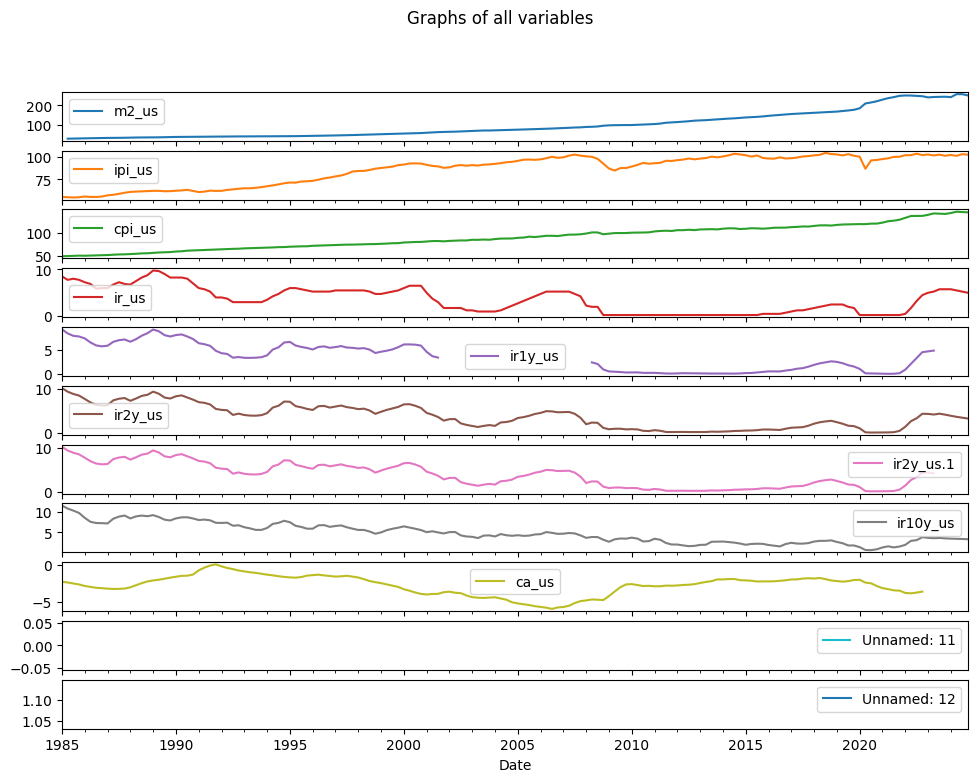

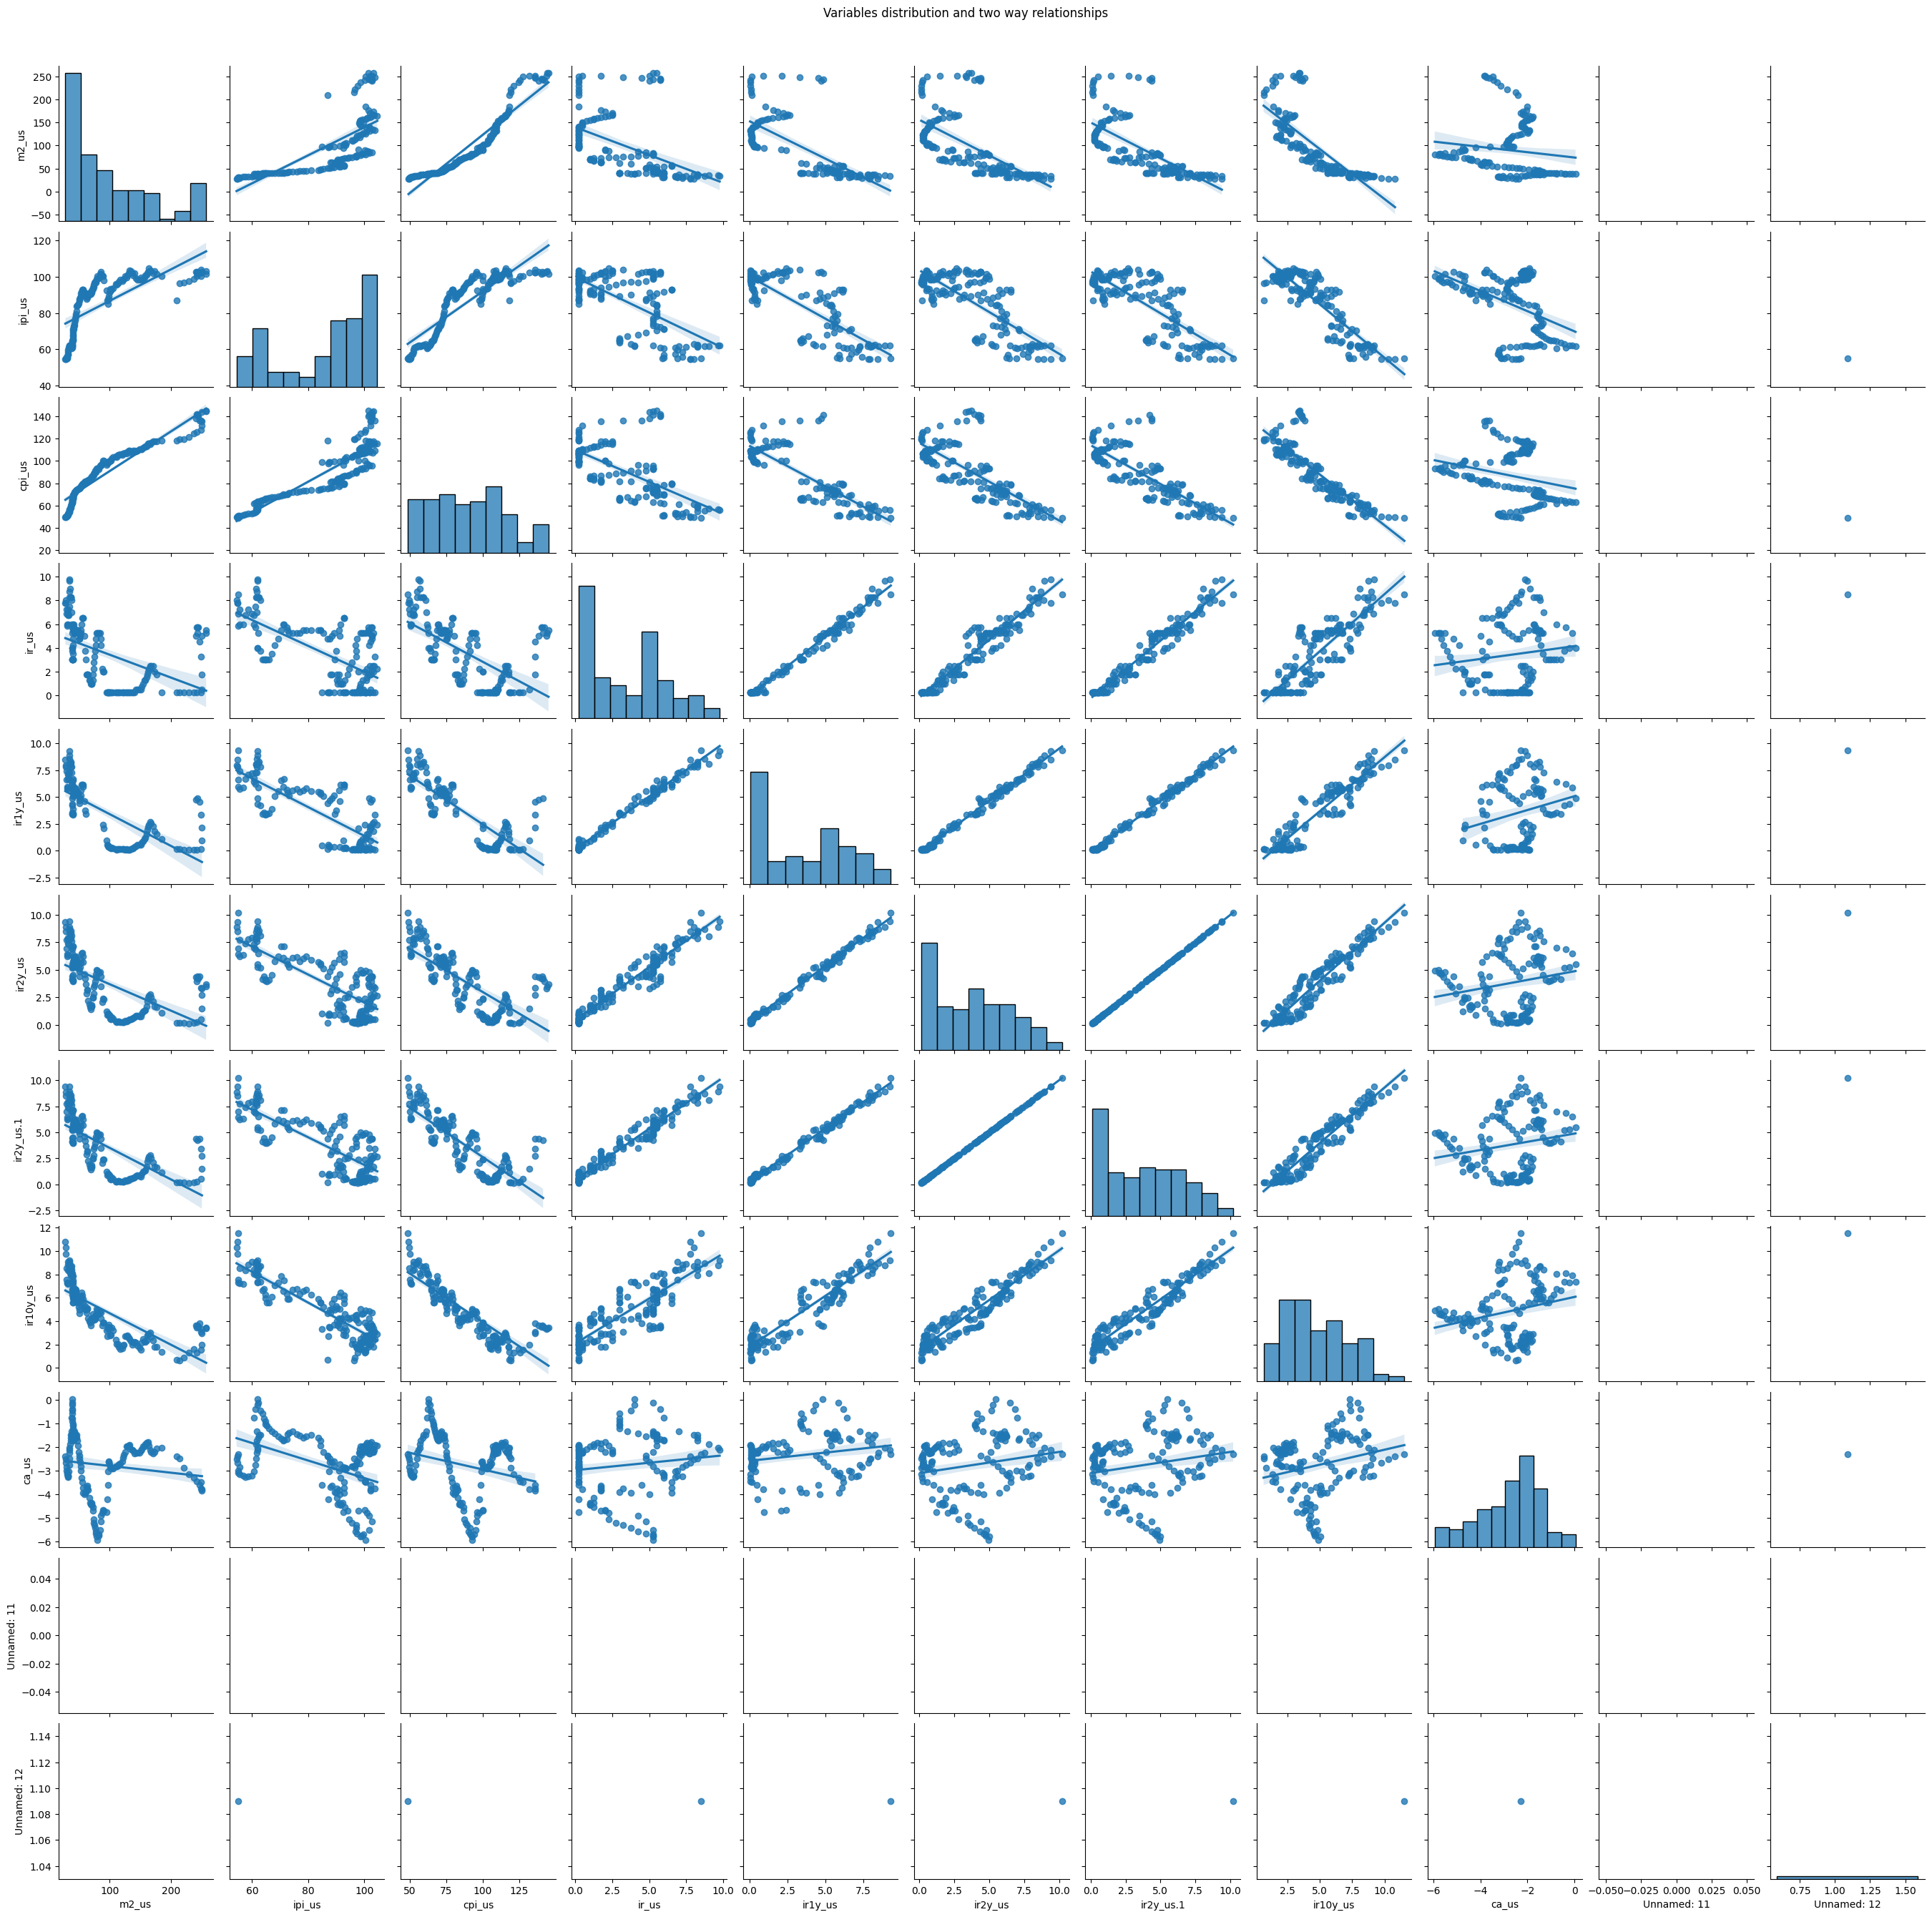

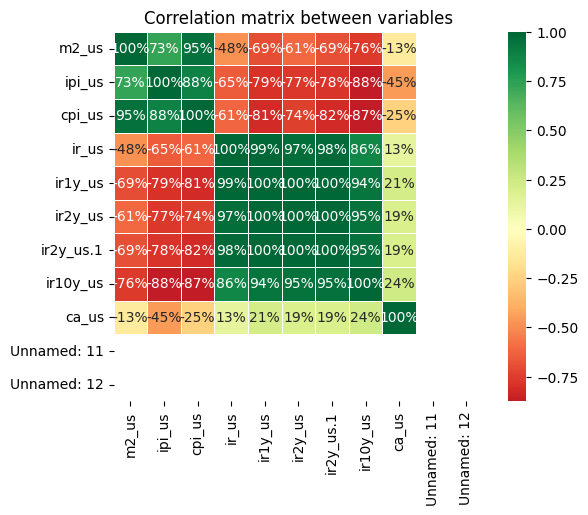

In [ ]:
#code to show exploratory data analysis

eda(data)

In [ ]:
#code to create specific dataframe for testing purposes to ensure no changes to original dataframe

arima_df = pd.DataFrame(data[input('Please put the columns you want to use for this ARIMA model seperated by space: ').split(" ")].copy(deep = True)).loc[input('Please insert model sample start date in YYYY-MM-DD format '):input('Please insert model sample end date in YYYY-MM-DD format ')].dropna()

Please put the columns you want to use for this ARIMA model seperated by space: ir10y_us cpi_us m2_us ipi_us
Please insert model sample start date in YYYY-MM-DD format 1985-01
Please insert model sample end date in YYYY-MM-DD format 2023-06


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 1985-06-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ir10y_us  153 non-null    float64
 1   cpi_us    153 non-null    float64
 2   m2_us     153 non-null    float64
 3   ipi_us    153 non-null    float64
dtypes: float64(4)
memory usage: 6.0 KB
None




,ir10y_us,cpi_us,m2_us,ipi_us
Date,,,,
1985-06-01,10.810081,49.289178,27.878921,54.726967
1985-09-01,10.312266,49.609832,28.385054,54.462833
1985-12-01,9.738355,50.067910,28.797587,54.733800
1986-03-01,8.541833,49.838871,29.271365,55.568433
1986-06-01,7.579094,50.159526,30.102209,55.048067
1986-09-01,7.282794,50.480180,30.827897,55.025100
1986-12-01,7.245823,50.617603,31.523542,55.519833
1987-03-01,7.173623,51.350528,31.820519,56.845500
1987-06-01,8.326460,51.991837,32.062030,57.518767


,ir10y_us,cpi_us,m2_us,ipi_us
Date,,,,
2021-03-01,1.312202,121.334289,229.273676,97.765400
2021-06-01,1.579955,124.457922,236.963895,98.607333
2021-09-01,1.317730,125.655338,242.249403,100.232833
2021-12-01,1.528845,127.713023,249.014023,100.374400
2022-03-01,1.945875,131.699217,250.734644,102.161467
2022-06-01,2.924622,135.733509,250.368333,102.199500
2022-09-01,3.096858,135.961173,248.723978,103.748933
2022-12-01,3.815849,135.956134,246.804601,102.319667
2023-03-01,3.647702,138.264389,240.821137,102.870967




Data summary statistics


,ir10y_us,cpi_us,m2_us,ipi_us
count,153.000000,153.000000,153.000000,153.000000
mean,4.786507,87.947643,91.848470,85.686068
std,2.401071,23.360136,61.181940,16.059708
min,0.645314,49.289178,27.878921,54.462833
25%,2.732356,68.574256,40.287271,70.478533
50%,4.563457,86.897370,72.459079,91.428167
75%,6.594662,107.258473,127.515499,99.012300
max,10.810081,141.298582,250.734644,104.672133


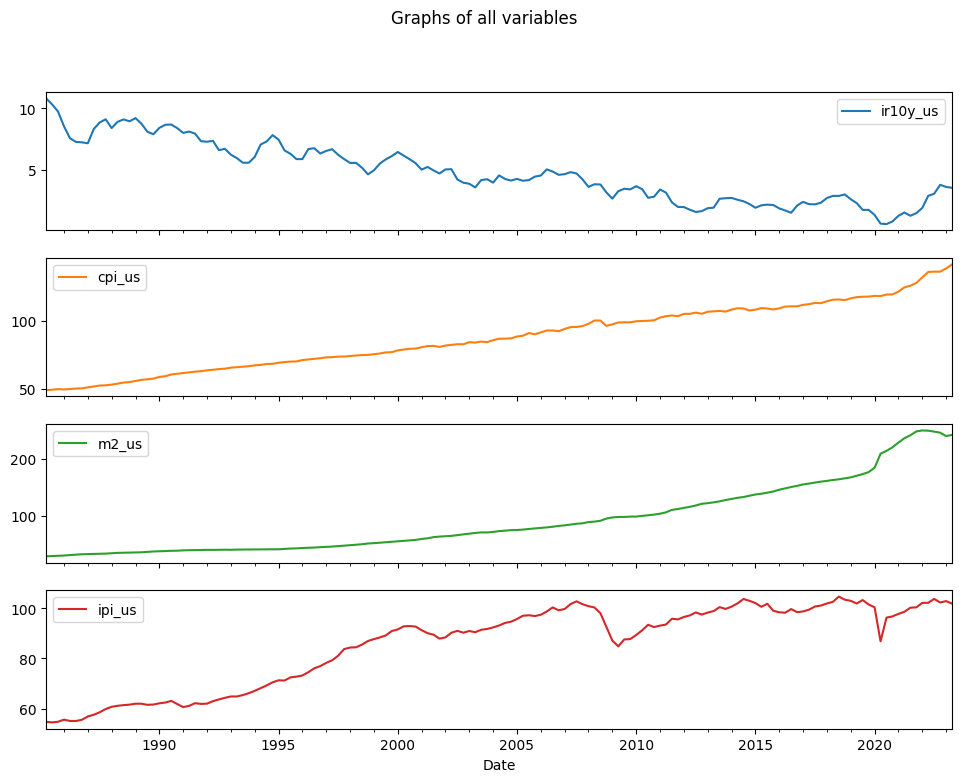

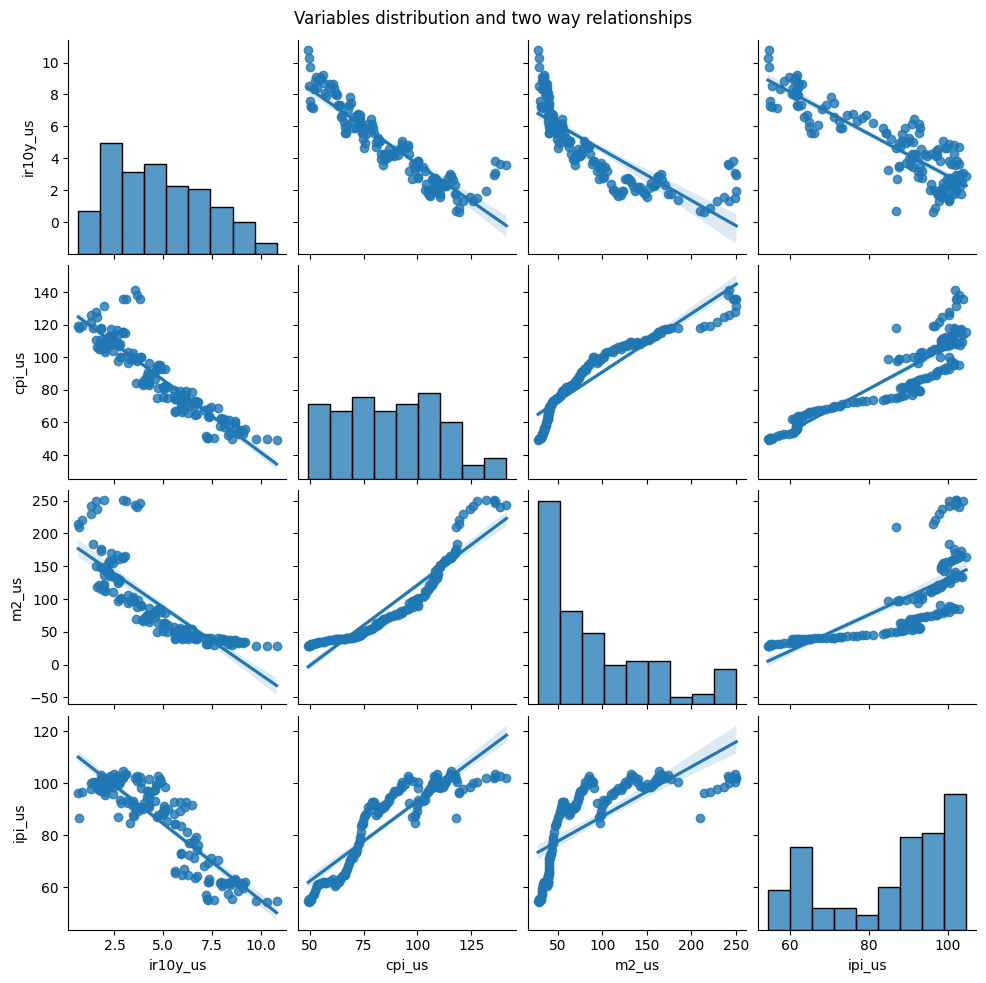

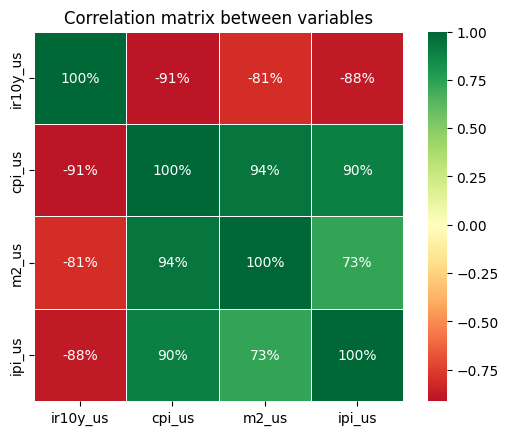

In [ ]:
#code for EDA

eda(arima_df)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.022320,0.022320,0.022320
1,cpi_us,0.879376,0.879376,0.879376
2,m2_us,1.000000,1.000000,1.000000
3,ipi_us,0.820014,0.820014,0.820014



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.094653,0.094653,0.094653
1,cpi_us,0.998417,0.998417,0.998417
2,m2_us,1.000000,1.000000,1.000000
3,ipi_us,0.420709,0.420709,0.420709



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,ir10y_us,0.012172,0.012172,0.012172
1,cpi_us,0.100000,0.100000,0.100000
2,m2_us,0.010000,0.010000,0.010000
3,ipi_us,0.010000,0.010000,0.010000


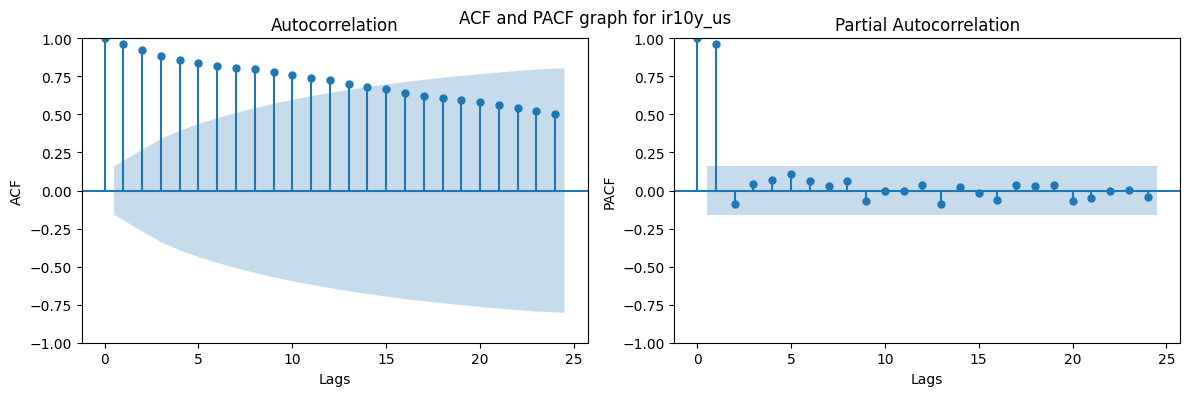

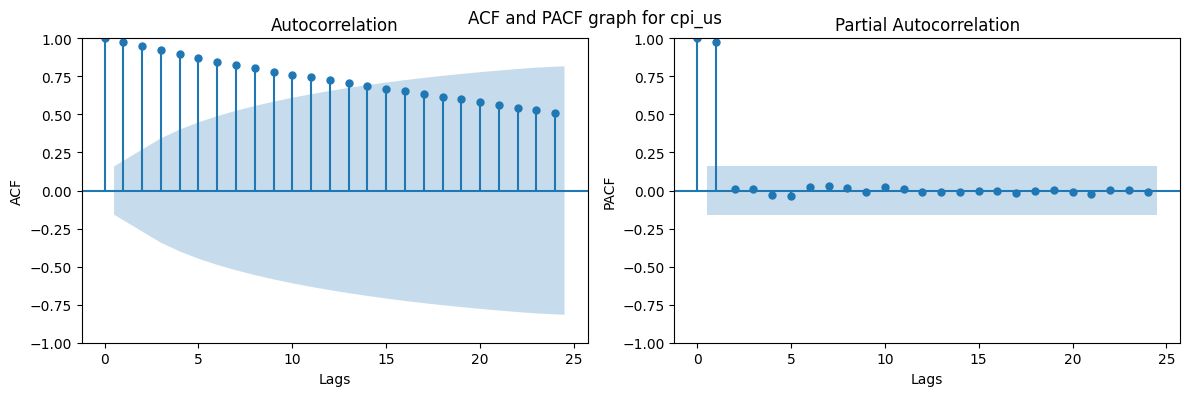

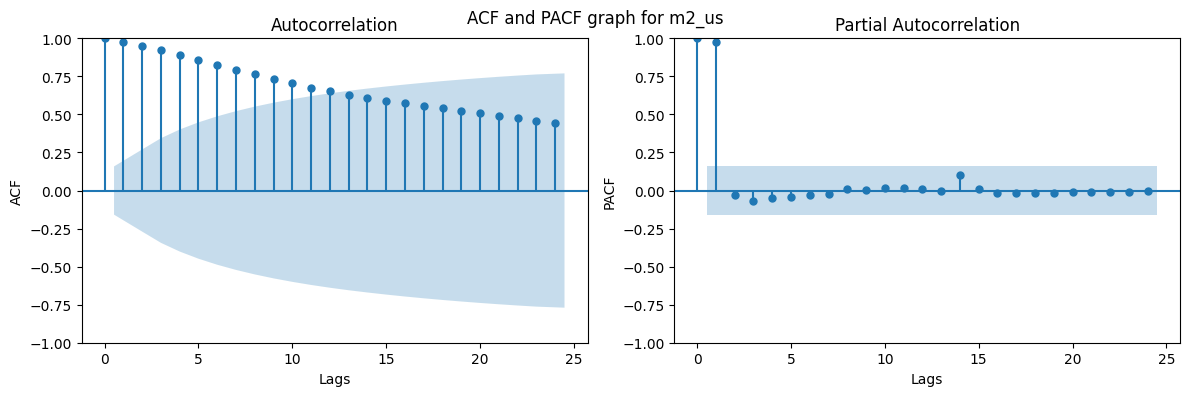

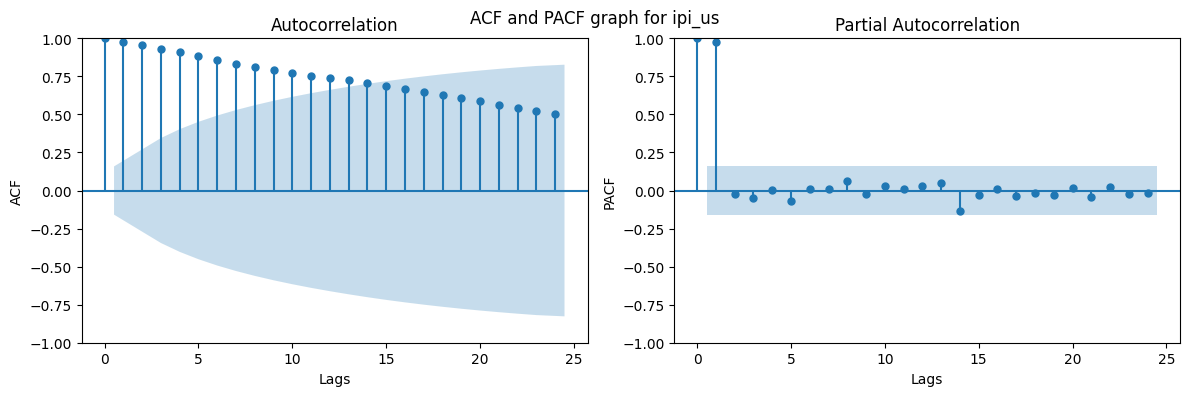

In [ ]:
# code to do stationary test

stationarity_test(arima_df)
print()
print()
acf_pacf_graph(arima_df)

In [ ]:
# code to transform data, dropna is optional

arima_df_transformed = transform_data(arima_df).dropna()

1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 1985-06-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ir10y_us  153 non-null    float64
 1   cpi_us    153 non-null    float64
 2   m2_us     153 non-null    float64
 3   ipi_us    153 non-null    float64
dtypes: float64(4)
memory usage: 6.0 KB
None




,ir10y_us,cpi_us,m2_us,ipi_us
Date,,,,
1985-06-01,10.810081,49.289178,27.878921,54.726967
1985-09-01,10.312266,49.609832,28.385054,54.462833
1985-12-01,9.738355,50.067910,28.797587,54.733800
1986-03-01,8.541833,49.838871,29.271365,55.568433
1986-06-01,7.579094,50.159526,30.102209,55.048067
1986-09-01,7.282794,50.480180,30.827897,55.025100
1986-12-01,7.245823,50.617603,31.523542,55.519833
1987-03-01,7.173623,51.350528,31.820519,56.845500
1987-06-01,8.326460,51.991837,32.062030,57.518767


,ir10y_us,cpi_us,m2_us,ipi_us
Date,,,,
2021-03-01,1.312202,121.334289,229.273676,97.765400
2021-06-01,1.579955,124.457922,236.963895,98.607333
2021-09-01,1.317730,125.655338,242.249403,100.232833
2021-12-01,1.528845,127.713023,249.014023,100.374400
2022-03-01,1.945875,131.699217,250.734644,102.161467
2022-06-01,2.924622,135.733509,250.368333,102.199500
2022-09-01,3.096858,135.961173,248.723978,103.748933
2022-12-01,3.815849,135.956134,246.804601,102.319667
2023-03-01,3.647702,138.264389,240.821137,102.870967




Data summary statistics


,ir10y_us,cpi_us,m2_us,ipi_us
count,153.000000,153.000000,153.000000,153.000000
mean,4.786507,87.947643,91.848470,85.686068
std,2.401071,23.360136,61.181940,16.059708
min,0.645314,49.289178,27.878921,54.462833
25%,2.732356,68.574256,40.287271,70.478533
50%,4.563457,86.897370,72.459079,91.428167
75%,6.594662,107.258473,127.515499,99.012300
max,10.810081,141.298582,250.734644,104.672133


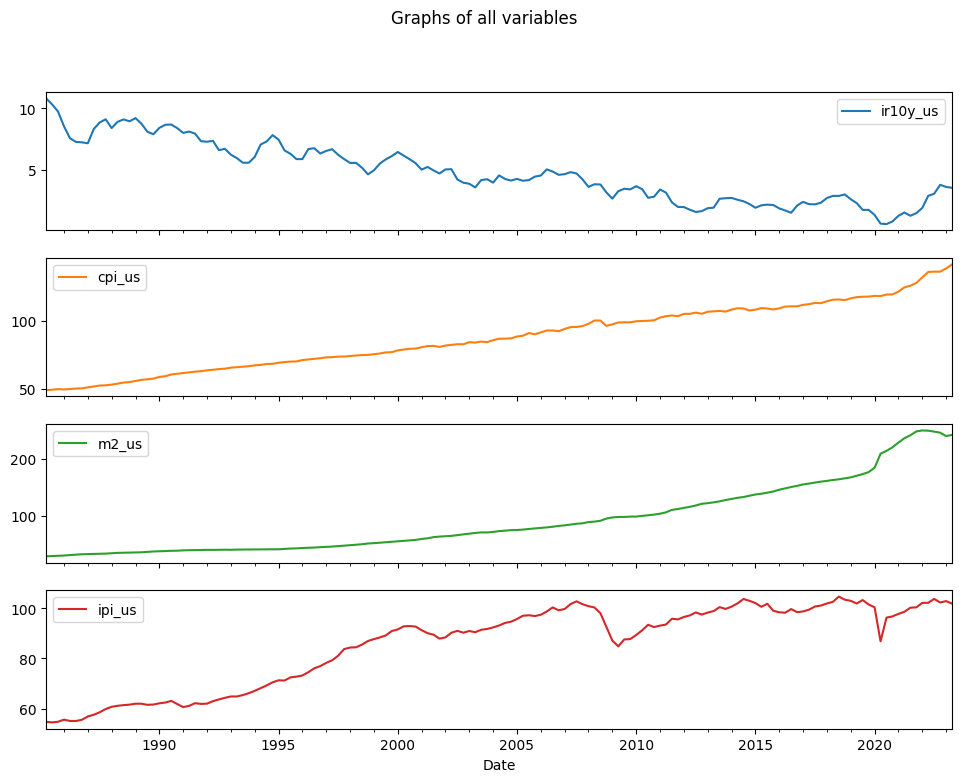

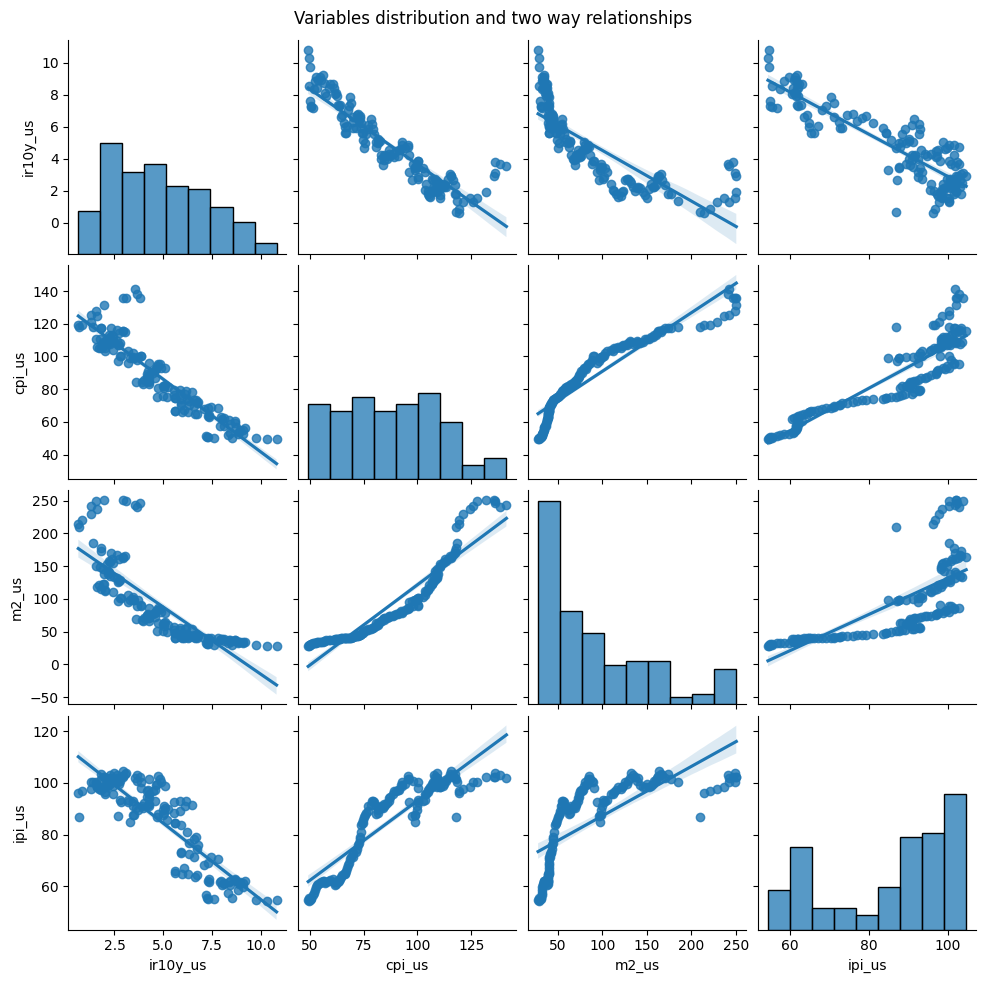

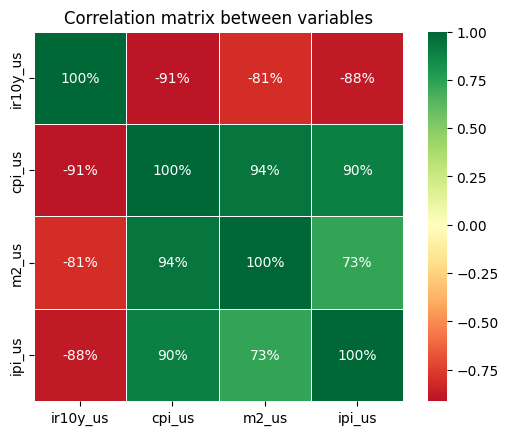

In [ ]:
#code for eda

eda(arima_df_transformed)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.022320,0.022320,0.022320
1,cpi_us,0.879376,0.879376,0.879376
2,m2_us,1.000000,1.000000,1.000000
3,ipi_us,0.820014,0.820014,0.820014



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.094653,0.094653,0.094653
1,cpi_us,0.998417,0.998417,0.998417
2,m2_us,1.000000,1.000000,1.000000
3,ipi_us,0.420709,0.420709,0.420709



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-0d2427176602>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,ir10y_us,0.012172,0.012172,0.012172
1,cpi_us,0.100000,0.100000,0.100000
2,m2_us,0.010000,0.010000,0.010000
3,ipi_us,0.010000,0.010000,0.010000


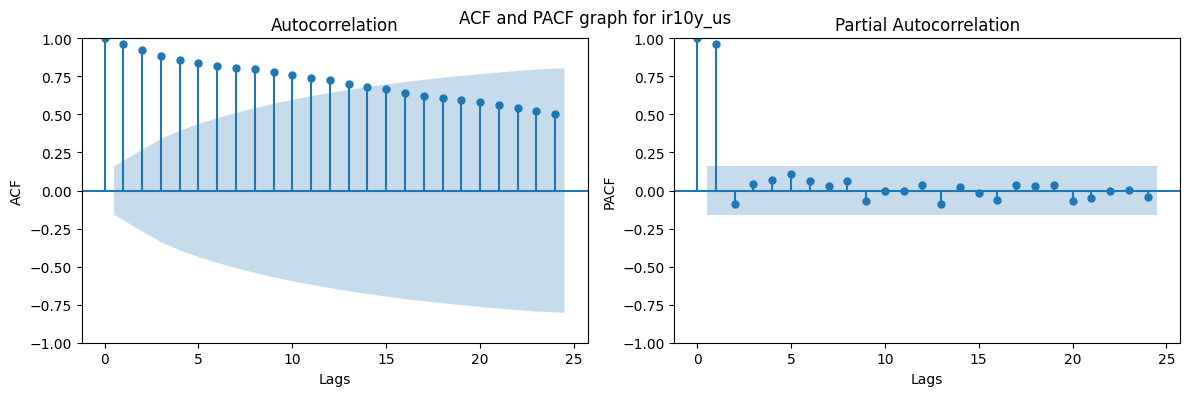

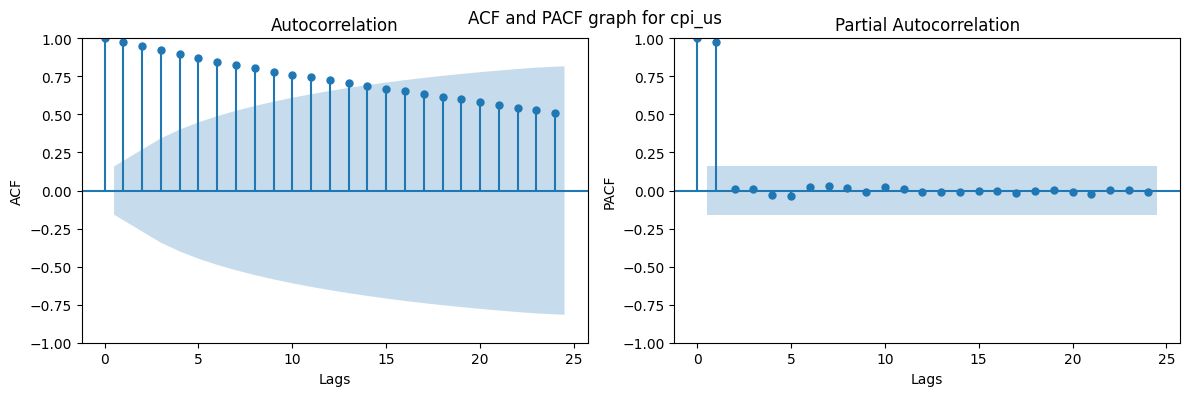

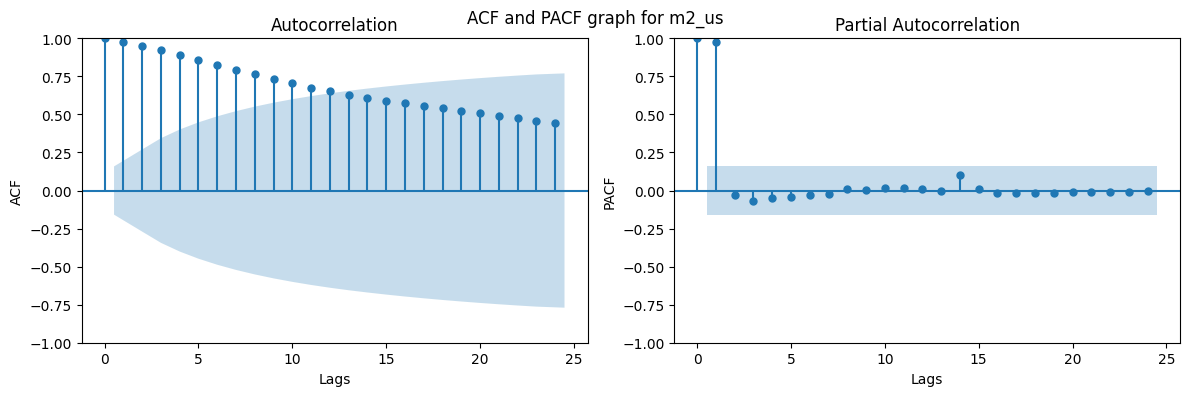

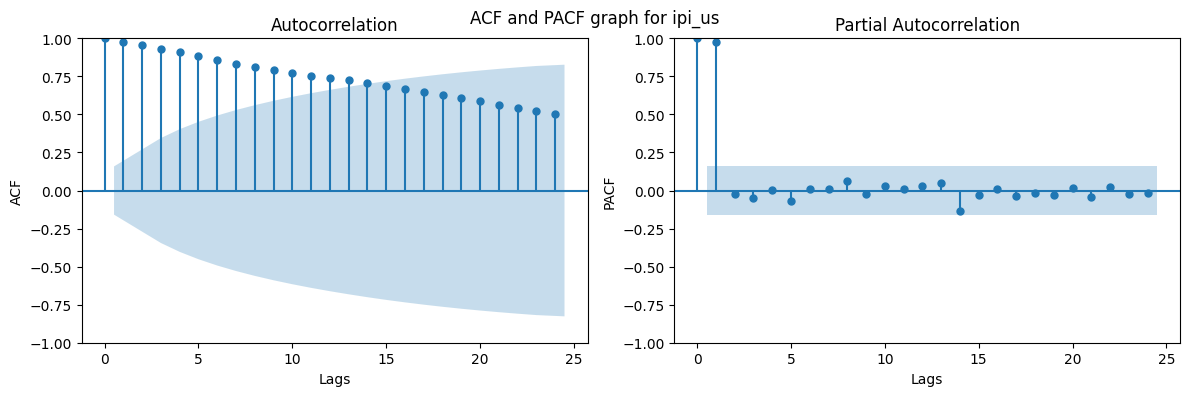

In [ ]:
# code to do stationary test

stationarity_test(arima_df_transformed)
print()
print()
acf_pacf_graph(arima_df_transformed)

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0

Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the data: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use


Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


                               SARIMAX Results                                
Dep. Variable:               ir10y_us   No. Observations:                  134
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -54.946
Date:                Sat, 07 Oct 2023   AIC                            117.893
Time:                        15:20:46   BIC                            129.484
Sample:                    03-01-1990   HQIC                           122.603
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8790      1.172      4.163      0.000       2.582

,10%,5%,1%
0,0.170832,0.170832,0.170832




Jarque Bera test for normality: H0 is standadised residual shows normality


,10%,5%,1%
0,0.317494,0.317494,0.317494




Ljung-Box test for serial correlation: H0 is no serial correlation up to lag 24


,10%,5%,1%
0,0.098925,0.098925,0.098925


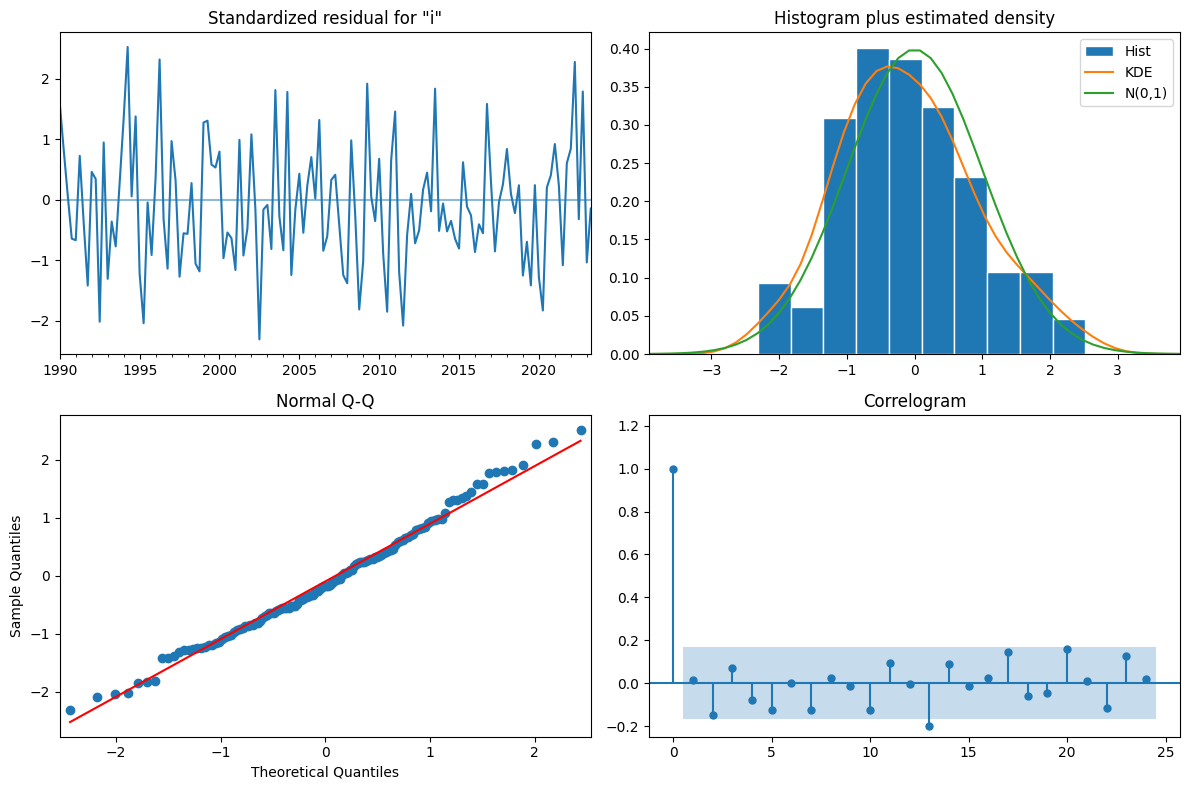





Enter the Y label name and unit ir10y_us/usd


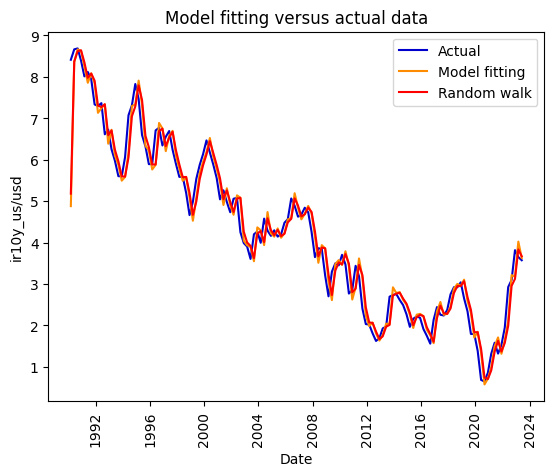



Please put model name: arima
Please put dependent variable name: ir10y_us
Forecast Accuracy of: arima  used to forecast  ir10y_us
mape   :  0.0919
me     :  0.0118
mae    :  0.3136
mpe    :  0.0164
rmse   :  0.4692
corr   :  0.9721
minmax :  0.0825


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0952
me     :  0.0238
mae    :  0.3187
mpe    :  0.0208
rmse   :  0.4633
corr   :  0.973
minmax :  0.0845


In [ ]:
# code to fit ARIMA model together with testing

model, fit, predict, residual, actual = arima_model(data)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0

Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the data: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use


Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


Enter the Y label name and unit ir10y_us


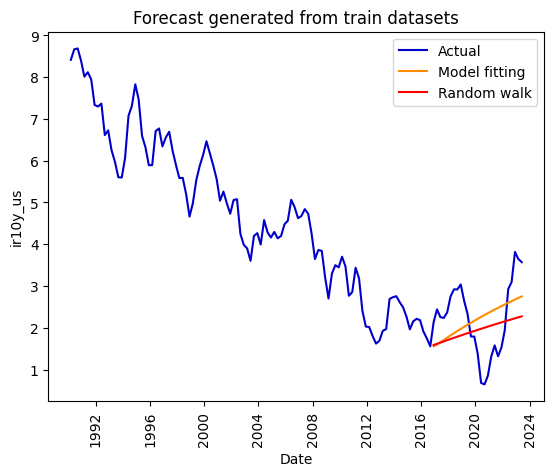



Please put model name: arima
Please put dependent variable name: ir10y_us
Forecast Accuracy of: arima  used to forecast  ir10y_us
mape   :  0.5554
me     :  -0.0291
mae    :  0.842
mpe    :  0.2477
rmse   :  0.9187
corr   :  0.0599
minmax :  0.3266


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.4839
me     :  -0.2765
mae    :  0.8301
mpe    :  0.1014
rmse   :  0.9174
corr   :  0.0775
minmax :  0.3276
RMSE for Four Quarters Ahead (Model Fitting): 0.646941852749634
RMSE for Four Quarters Ahead (Random Walk): 0.6457032359198124


In [ ]:
arima_simple_validation(actual)

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1985-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1

Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 1
Please put the desired seasonal AR process number: 4
Please pu

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use


Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 1
1 if need to invert diff, 0 if no need to invert diff: 1
1 if need to undo second differencing, 0 if only inversing first difference: 0
Please log the variables that was log before differenced
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to undo first differencing separated by space: ir10y_us
Column: ir10y_us
Please insert the number of difference for the first difference: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be inverted its log separated by space: ir10y_us


                                    SARIMAX Results                                     
Dep. Variable:                         ir10y_us   No. Observations:                  153
Model:             ARIMA(2, 0, 1)x(4, 0, [], 4)   Log Likelihood                 114.700
Date:                          Wed, 11 Oct

,10%,5%,1%
0,0.000000,0.000000,0.000000




Jarque Bera test for normality: H0 is standadised residual shows normality


,10%,5%,1%
0,0.000000,0.000000,0.000000




Ljung-Box test for serial correlation: H0 is no serial correlation up to lag 24


,10%,5%,1%
0,0.907793,0.907793,0.907793


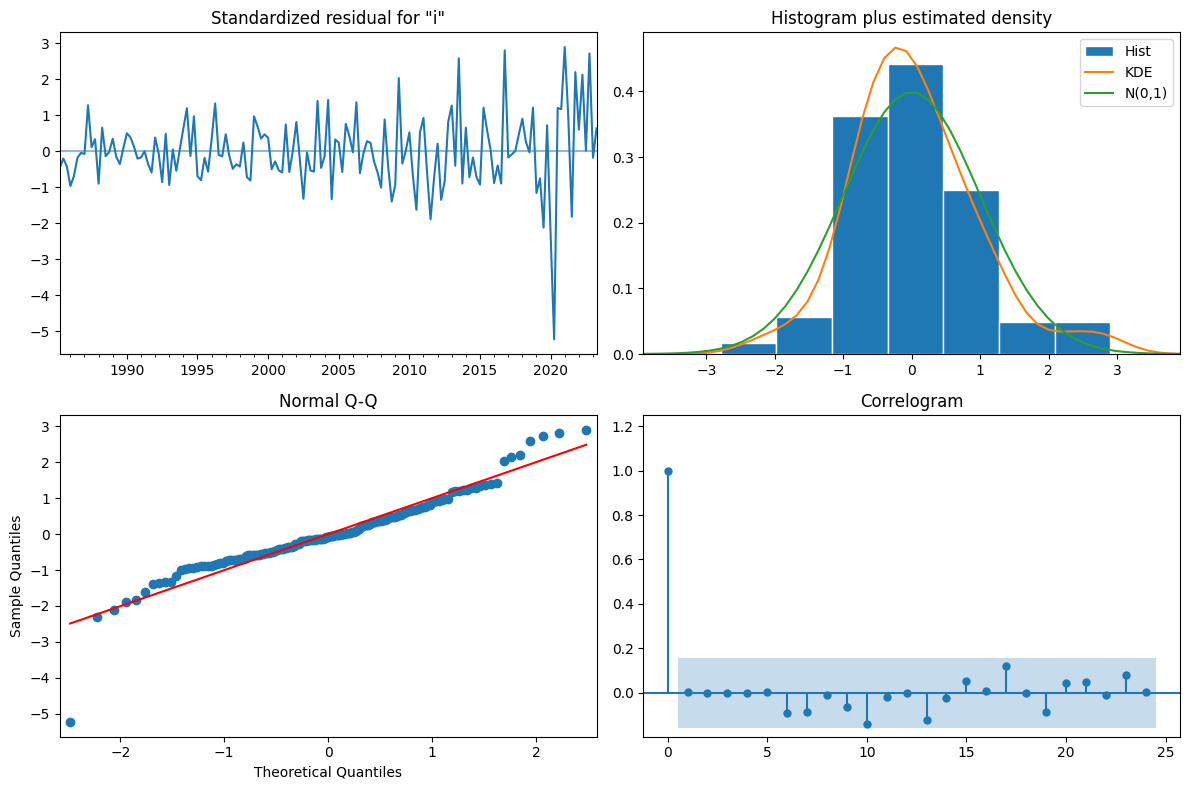





Enter the Y label name and unit ir10y_us


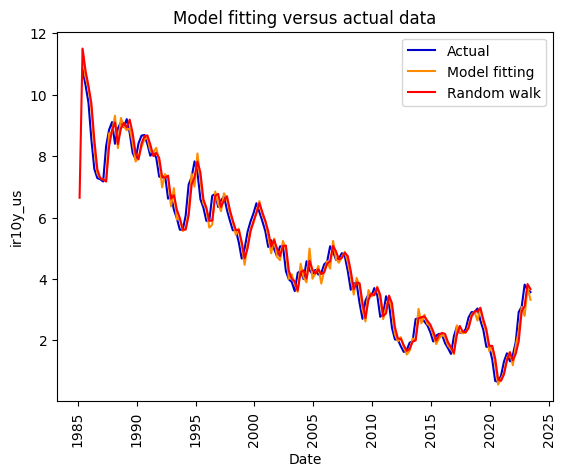



Please put model name: arima
Please put dependent variable name: ir10y_us
Forecast Accuracy of: arima  used to forecast  ir10y_us
mape   :  0.0819
me     :  0.0163
mae    :  0.3075
mpe    :  0.0072
rmse   :  0.3896
corr   :  0.9871
minmax :  0.0753


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0905
me     :  0.0315
mae    :  0.3527
mpe    :  0.0191
rmse   :  0.5656
corr   :  0.9732
minmax :  0.081


In [ ]:
# code to fit ARIMA model together with testing (2), for combination forecasting

model, fit, predict, residual, actual = arima_model(data)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1

Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 1
Please put the desired seasonal AR process number: 4
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-


Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 1
1 if need to invert diff, 0 if no need to invert diff: 1
1 if need to undo second differencing, 0 if only inversing first difference: 0
Please log the variables that was log before differenced
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to undo first differencing separated by space: ir10y_us
Column: ir10y_us
Please insert the number of difference for the first difference: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be inverted its log separated by space: ir10y_us


Enter the Y label name and unit ir10y_us


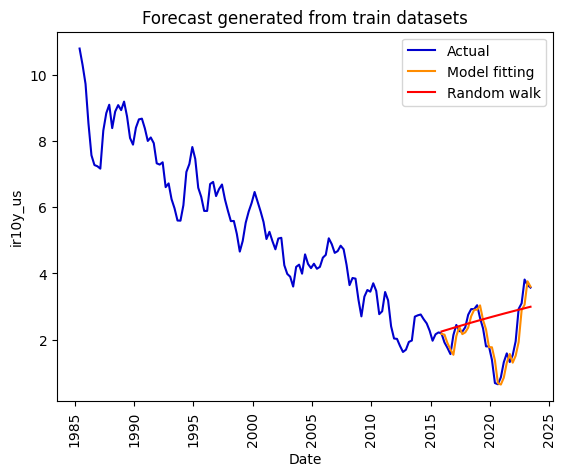



Please put model name: arima
Please put dependent variable name: ir10y_us
Forecast Accuracy of: arima  used to forecast  ir10y_us
mape   :  0.1624
me     :  -0.074
mae    :  0.2864
mpe    :  -0.0043
rmse   :  0.3693
corr   :  0.8989
minmax :  0.1392


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.5607
me     :  0.4575
mae    :  0.7148
mpe    :  0.4823
rmse   :  0.9382
corr   :  0.1496
minmax :  0.257
RMSE for the Second Quarter (Model Fitting): 0.23686431505856986
RMSE for the Third Quarter (Model Fitting): 0.147247431410519
RMSE for the Four Quarter (Model Fitting): 0.13969394161282334
RMSE for Four Quarters Ahead (Model Fitting): 0.15613418528677944
RMSE for Four Quarters Ahead (Random Walk): 0.5066485476429056


In [ ]:
arima_simple_validation(actual)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2
Sample transformation
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0

Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the data: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use


Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


Enter the Y label name and unit ir10y_us/usd


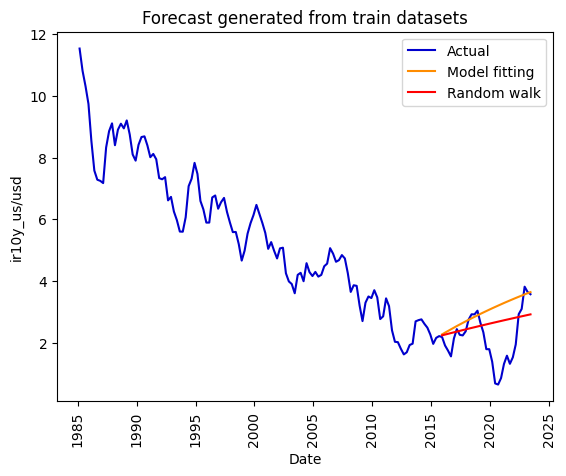



Please put model name: arima
Please put dependent variable name: ir10y_us
Forecast Accuracy of: arima  used to forecast  ir10y_us
mape   :  0.7101
me     :  0.829
mae    :  0.8716
mpe    :  0.6971
rmse   :  1.1983
corr   :  0.1396
minmax :  0.2796


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.5477
me     :  0.4165
mae    :  0.7079
mpe    :  0.4585
rmse   :  0.9165
corr   :  0.1514
minmax :  0.2572


,Rolling Window,MSE,RMSE
0,1,0.295535,0.543631
1,2,0.247371,0.497364
2,3,0.196308,0.443066
3,4,0.128763,0.358835
4,5,0.019986,0.141372
5,6,0.025456,0.159551
6,7,0.058963,0.242822
7,8,0.112203,0.334967
8,9,0.203555,0.451171
9,10,0.252464,0.502458



Average MSE: 0.6887138269827808

Average RMSE: 0.735820736737733


In [ ]:
arima_cross_validation(actual, window_size=5)